In [1]:
from itertools import chain
import numpy as np
from Bio.PDB import *
import os
import warnings
import matplotlib.pyplot as plt
import random
parser = PDBParser()
amino3CodesStr = 'alaargasnaspcysgluglnglyhisileleulysmetpheproserthrtrptyrval'
amino3Codes = [amino3CodesStr[x:x+3].upper() for x in range(0, len(amino3CodesStr), 3)]
amino3Codes = list(sorted(amino3Codes))
print(amino3Codes, len(amino3Codes)) 

['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'] 20


In [4]:
general_protein_triangles = []
os.makedirs("generalProteinSingle")
errorPDBNames = []
with open("generalData\pdb_4960list.txt", "r") as f:
    for l in f.readlines():
        lineList = l.strip().split()
        pdbName = lineList[1] + '.pdb'
        chainNames = [lineList[2], lineList[5]]
        if chainNames[0] != chainNames[1]:
            # add to the official list
            protein = parser.get_structure(pdbName[:-4], "cleanGeneral/"+pdbName)
            chains = list(list(protein.get_models())[0].get_chains())
            resA, resB = [], []
            for x in chains:
                if x.id == chainNames[0]:
                    resA = list(x.get_residues())
                if x.id == chainNames[1]:
                    resB = list(x.get_residues())
            AAtomList = list(chain.from_iterable([list(x.get_atoms()) for x in resA if x.get_resname() in amino3Codes]))
            BAtomList = list(chain.from_iterable([list(x.get_atoms()) for x in resB if x.get_resname() in amino3Codes]))
            if len(AAtomList) == 0 or len(BAtomList) == 0:
                errorPDBNames.append(pdbName)
                continue
            NBSearch = NeighborSearch(AAtomList)
            InteractingAList = []
            for res in resB:
                for atm in list(res.get_atoms()):
                    centerPos = atm.coord
                    if len(NBSearch.search(centerPos, 5, 'R')) > 0:
                        InteractingAList.append(res)
                        break

            AInteractionList = {}
            for i in range(len(amino3Codes)):
                for j in range(i, len(amino3Codes)):
                    combinationName = amino3Codes[i] + " " + amino3Codes[j]
                    AInteractionList[combinationName] = 0

            atms = [r.get_atoms() for r in InteractingAList if r.get_resname() in amino3Codes]
            if len(atms) > 0:
                NBSearch2 = NeighborSearch(list(chain.from_iterable(atms))) # Count interactions using neighbor search
                AInteractions = NBSearch2.search_all(5, level='R')
                for (r1, r2) in AInteractions:
                    combinationName = min([r1.get_resname(), r2.get_resname()]) + " " + max([r1.get_resname(), r2.get_resname()])
                    AInteractionList[combinationName] += 1
                    
                AfreqChart = np.empty((20, 20))
                AfreqChart.fill(np.nan)
                for r in range(len(amino3Codes)):
                    for c in range(r, len(amino3Codes)):
                        fst, snd = amino3Codes[r], amino3Codes[c]
                        combinationName = fst + " " + snd
                        count = AInteractionList[combinationName]
                        AfreqChart[r, c] = count

                # Normalize
                AfreqChart -= np.nanmin(AfreqChart)
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    try:
                        AfreqChart /= (np.nanmax(AfreqChart) - np.nanmin(AfreqChart))
                    except:
                        errorPDBNames.append(pdbName)
                        continue
                    AfreqChart = np.nan_to_num(AfreqChart)

                ### Save
                with open("generalProteinSingle/FreqChart"+pdbName[:-4]+".npy", "wb") as f:
                    np.save(f, AfreqChart)
            else:
                errorPDBNames.append(pdbName)

c:\Python310\lib\site-packages\Bio\PDB\Atom.py:232: PDBConstructionWarning: Could not assign element 'X' for Atom (name=XE1) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)
c:\Python310\lib\site-packages\Bio\PDB\Atom.py:232: PDBConstructionWarning: Could not assign element 'X' for Atom (name=XE2) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)


In [5]:
print(len(errorPDBNames), errorPDBNames)

7 ['1gu8.pdb', '2vo1.pdb', '1cm4.pdb', '1pci.pdb', '1cjl.pdb', '2cse.pdb', '1lhg.pdb']


In [6]:
print(len(os.listdir("generalProteinSingle")))

3218


In [7]:
print(len(os.listdir("AgFreqChart")))

1215


In [15]:
data, labels = [], []
random.seed(9001)
randomIndex = random.sample(range(len(os.listdir("generalProteinSingle"))), len(os.listdir("AgFreqChart")))
generalProteinDir = os.listdir("generalProteinSingle")
selectedGeneralNames = [generalProteinDir[x] for x in randomIndex] 
for filename in os.listdir("AgFreqChart"):
    data.append(np.nan_to_num(np.load("AgFreqChart/"+filename)))
    labels.append(1)
for fname in selectedGeneralNames:
    data.append(np.nan_to_num(np.load("generalProteinSingle/"+fname)))
    labels.append(0)
data = np.array(data)
labels = np.array(labels).reshape(-1, 1)

In [9]:
# data, labels = [], []
# for filename in os.listdir("AgFreqChart"):
#     data.append(np.nan_to_num(np.load("AgFreqChart/"+filename)))
#     labels.append(1)
# for filename in os.listdir("generalProteinSingle"):
#     data.append(np.nan_to_num(np.load("generalProteinSingle/"+filename)))
#     labels.append(0)
# data = np.array(data)
# labels = np.array(labels).reshape(-1, 1)

In [16]:
len(data)

2430

### Display example (boundary is 1214/1215)

(20, 20)


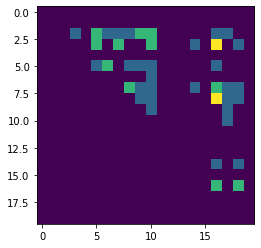

In [17]:
plt.imshow(data[1214])
print(data[0].shape)

# ML
## Create model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, Dropout
from keras import applications
def create_model():
    # base_model=applications.VGG16(include_top=False, weights='imagenet',input_tensor=Input(shape=(20, 21, 1)))
    # for layer in base_model.layers:
    #     layer.trainable = False
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(20,20,1)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

### ROC Curve

In [19]:
def plot_roc_curve(fpr, tpr):
    fig = plt.figure(figsize=(15, 15)) 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.title("ROC Curve for Antigen-Only Internal Residue Combination Frequency Chart Prediction")
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    

## Run Model

Epoch 1/1000
157/157 [==============================] - 3s 13ms/step - loss: 0.6923 - accuracy: 0.5304 - precision_2: 0.6250 - recall_2: 0.1510 - val_loss: 0.6901 - val_accuracy: 0.6461 - val_precision_2: 0.6286 - val_recall_2: 0.7213
Epoch 2/1000
157/157 [==============================] - 2s 12ms/step - loss: 0.6899 - accuracy: 0.5921 - precision_2: 0.5789 - recall_2: 0.6743 - val_loss: 0.6869 - val_accuracy: 0.6255 - val_precision_2: 0.6240 - val_recall_2: 0.6393
Epoch 3/1000
157/157 [==============================] - 2s 12ms/step - loss: 0.6871 - accuracy: 0.5967 - precision_2: 0.5813 - recall_2: 0.6898 - val_loss: 0.6825 - val_accuracy: 0.6584 - val_precision_2: 0.6403 - val_recall_2: 0.7295
Epoch 4/1000
157/157 [==============================] - 2s 12ms/step - loss: 0.6825 - accuracy: 0.6155 - precision_2: 0.5969 - recall_2: 0.7100 - val_loss: 0.6754 - val_accuracy: 0.6420 - val_precision_2: 0.6733 - val_recall_2: 0.5574
Epoch 5/1000
157/157 [==============================] - 2s 1

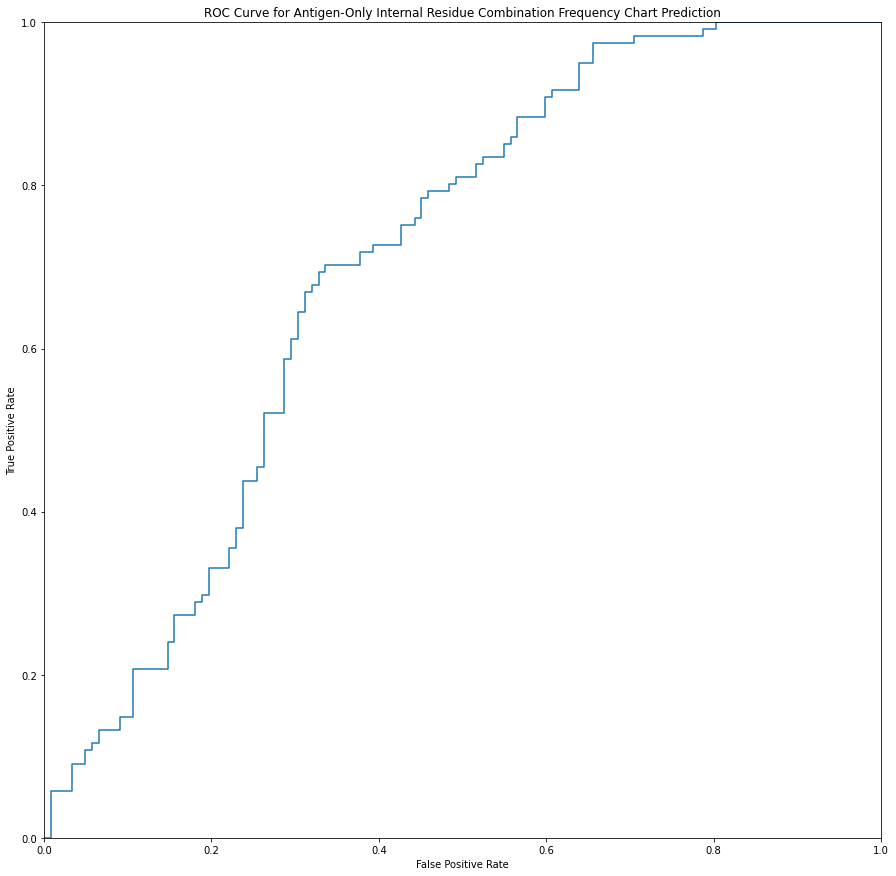

0.7024793388429753
[0.71111111 0.58215292 0.76000542 0.69411606 0.76529603 0.72555238]


In [20]:
from sklearn.model_selection import StratifiedKFold
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.metrics import roc_curve, roc_auc_score

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=9001)
accs, aucs, losses, precs, recs, f1s = [np.zeros(10) for _ in range(6)]

for i, (trainInds, testInds) in enumerate(kfold.split(data, labels)):
    # if i == 1:
    #     break
    model = create_model()
    X_train, X_test, y_train, y_test = data[trainInds], data[testInds], labels[trainInds], labels[testInds]
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy', Precision(), Recall()])
    
    # best_weights_file="weights.best.hdf5"
    # checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    es = EarlyStopping('val_accuracy', patience=15, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=1000, batch_size=14,
                        validation_data=(X_test, y_test), callbacks=(es))
    # print(model.metrics_names)
    test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=1)
    accs[i] = test_acc
    losses[i] = test_loss
    precs[i] = test_prec
    recs[i] = test_rec
    test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
    f1s[i] = test_f1
    prediction = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    auc_score=roc_auc_score(y_test, prediction)
    aucs[i] = auc_score
    if i == 9:
        plot_roc_curve(fpr,tpr)
        print(auc_score)

print(np.mean(np.array([accs, losses, aucs, precs, recs, f1s]), axis=1))